In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from utils import *
from utils import get_optout_probability

In [51]:
fits_folder = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
all_files = [f for f in os.listdir(fits_folder) if f.endswith("_Fits_NFoldCV.mat")]
all_data = {}
for fn in all_files:
    rat = fn.split("_")[0]
    mat = load_mat_file(os.path.join(fits_folder, fn))
    if "BestFit_Folds" in mat:
        all_data[rat] = mat["BestFit_Folds"]
    else:
        print("skipping", fn)

In [52]:
fitted, trains, tests = [], [], []
for rat, folds in all_data.items():
    # best‐fit params table
    p = extract_bestfit_params(folds)
    p["rat"] = rat
    p["Fold"] = p.index
    fitted.append(p)
    # raw behavior
    tdf = extract_train_trials(folds, rat)
    tsf = extract_test_trials(folds, rat)
    trains.append(tdf)
    tests.append(tsf)

fitted_df = pd.concat(fitted, ignore_index=True)
train_df = pd.concat(trains, ignore_index=True)
test_df = pd.concat(tests, ignore_index=True)
print("fitted:", fitted_df.shape, "train:", train_df.shape, "test:", test_df.shape)

fitted: (1550, 7) train: (34714700, 15) test: (8678675, 15)


In [53]:
# merge fitted params with behavioral data
train_merged = train_df.merge(fitted_df, on=["rat", "Fold"], how="left")
test_merged = test_df.merge(fitted_df, on=["rat", "Fold"], how="left")

# trial index within each fold
train_merged["trial_in_fold"] = train_merged.groupby(["rat", "Fold"]).cumcount()
test_merged["trial_in_fold"] = test_merged.groupby(["rat", "Fold"]).cumcount()

# drop violations & long waits
train_merged = train_merged.query("vios==0 and wait_time<=30")
test_merged = test_merged.query("vios==0 and wait_time<=30")

print("Merged data shapes - train:", train_merged.shape, "test:", test_merged.shape)

Merged data shapes - train: (20245448, 21) test: (5061362, 21)


In [54]:
# param5 is λ (lambda) - using tertiles to create 3 bins (lowest 33%, middle 33%, highest 33%)
lam = (
    fitted_df
    .groupby("rat")["param5"]
    .median()
    .reset_index()
    .rename(columns={"param5": "lambda_median"})
)

# calculate tertiles
lambda_tertiles = np.percentile(lam["lambda_median"], [33.33, 66.67])
print(f"lambda tertiles: {lambda_tertiles[0]:.3f}, {lambda_tertiles[1]:.3f}")

# create 3 bins based on tertiles
def assign_inference_type(lambda_val):
    if lambda_val < lambda_tertiles[0]:
        return "poor"
    elif lambda_val < lambda_tertiles[1]:
        return "medium"
    else:
        return "good"

lam["inference_type"] = lam["lambda_median"].apply(assign_inference_type)

# print classification summary
print(f"classification based on lambda (param5) tertiles:")
for inf_type in ["poor", "medium", "good"]:
    count = len(lam[lam['inference_type'] == inf_type])
    lambda_range = lam[lam['inference_type'] == inf_type]['lambda_median']
    print(f"- {inf_type} inference: n={count} rats, λ range: {lambda_range.min():.3f} to {lambda_range.max():.3f}")

# add label back to merged tables
train_merged = train_merged.merge(lam, on="rat", how="left")
test_merged = test_merged.merge(lam, on="rat", how="left")

# create per-rat wait time curves, then plot examples, mean, and standard deviation separately
def create_per_rat_curves(df):
    """create per-rat, per-trial-index wait time curves"""
    per_rat_curves = {}

    for rat in df['rat'].unique():
        rat_data = df[df['rat'] == rat]
        rat_curve = rat_data.groupby('trial_in_fold')['wait_time'].mean()
        per_rat_curves[rat] = rat_curve

    return per_rat_curves

# get per-rat curves for each inference type
inference_types = ["poor", "medium", "good"]
all_rat_curves = {}

for inf_type in inference_types:
    subset = train_merged[train_merged['inference_type'] == inf_type]
    all_rat_curves[inf_type] = create_per_rat_curves(subset)

# find minimum length across all rats for consistent plotting
min_length = float('inf')
for inf_type in inference_types:
    for rat, curve in all_rat_curves[inf_type].items():
        min_length = min(min_length, len(curve))

print(f"minimum curve length across all rats: {min_length}")

lambda tertiles: 0.390, 0.803
classification based on lambda (param5) tertiles:
- poor inference: n=103 rats, λ range: 0.000 to 0.376
- medium inference: n=104 rats, λ range: 0.391 to 0.803
- good inference: n=103 rats, λ range: 0.807 to 0.996
minimum curve length across all rats: 3392


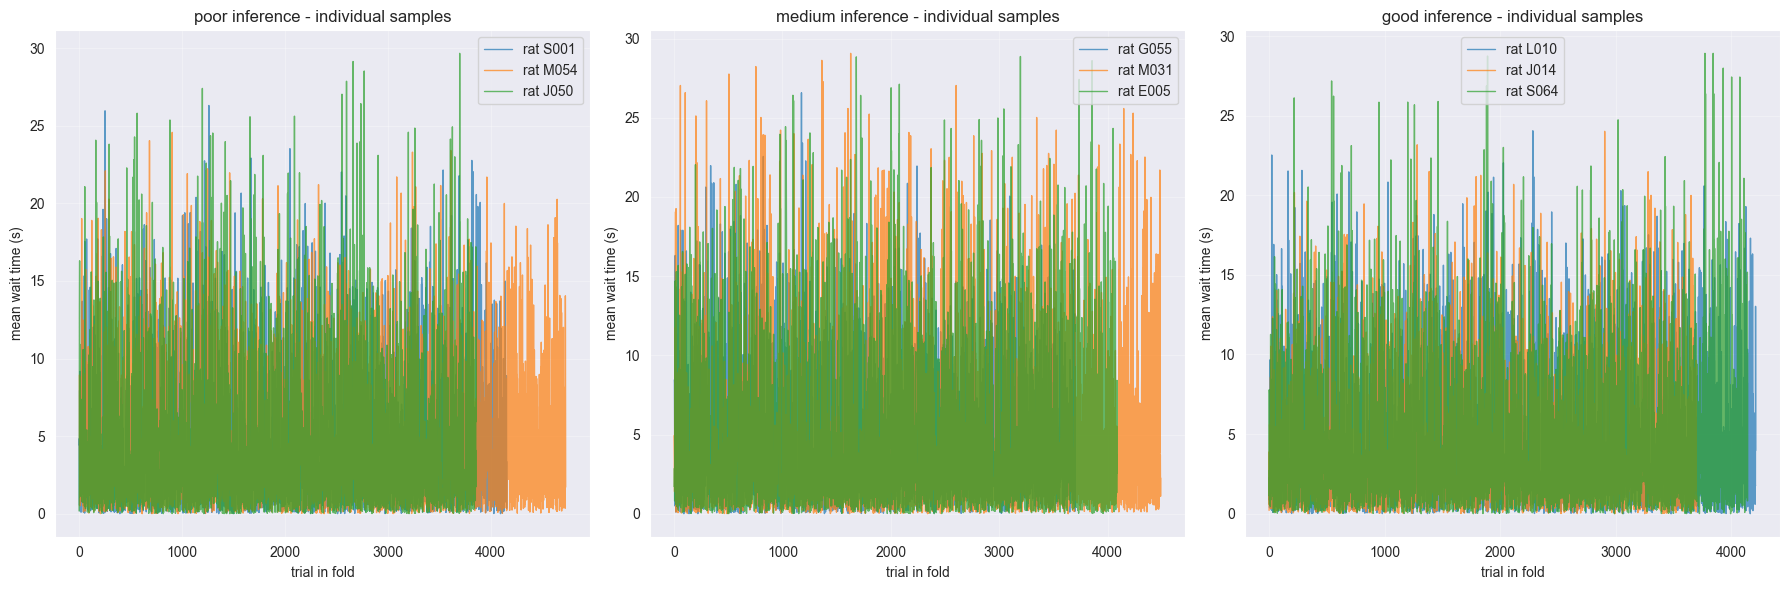

In [55]:
# plot 1: individual rat samples (few samples per inference type)
colors = {'poor': 'red', 'medium': 'orange', 'good': 'blue'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, inf_type in enumerate(inference_types):
    ax = axes[i]
    
    # plot first 3 rat samples
    rats_to_plot = list(all_rat_curves[inf_type].keys())[:3]
    
    for rat in rats_to_plot:
        curve = all_rat_curves[inf_type][rat]
        trimmed_curve = curve.iloc[:min_length]
        ax.plot(trimmed_curve.index, trimmed_curve.values, 
                alpha=0.7, linewidth=1, label=f'rat {rat}')
    
    ax.set_title(f'{inf_type} inference - individual samples')
    ax.set_xlabel('trial in fold')
    ax.set_ylabel('mean wait time (s)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

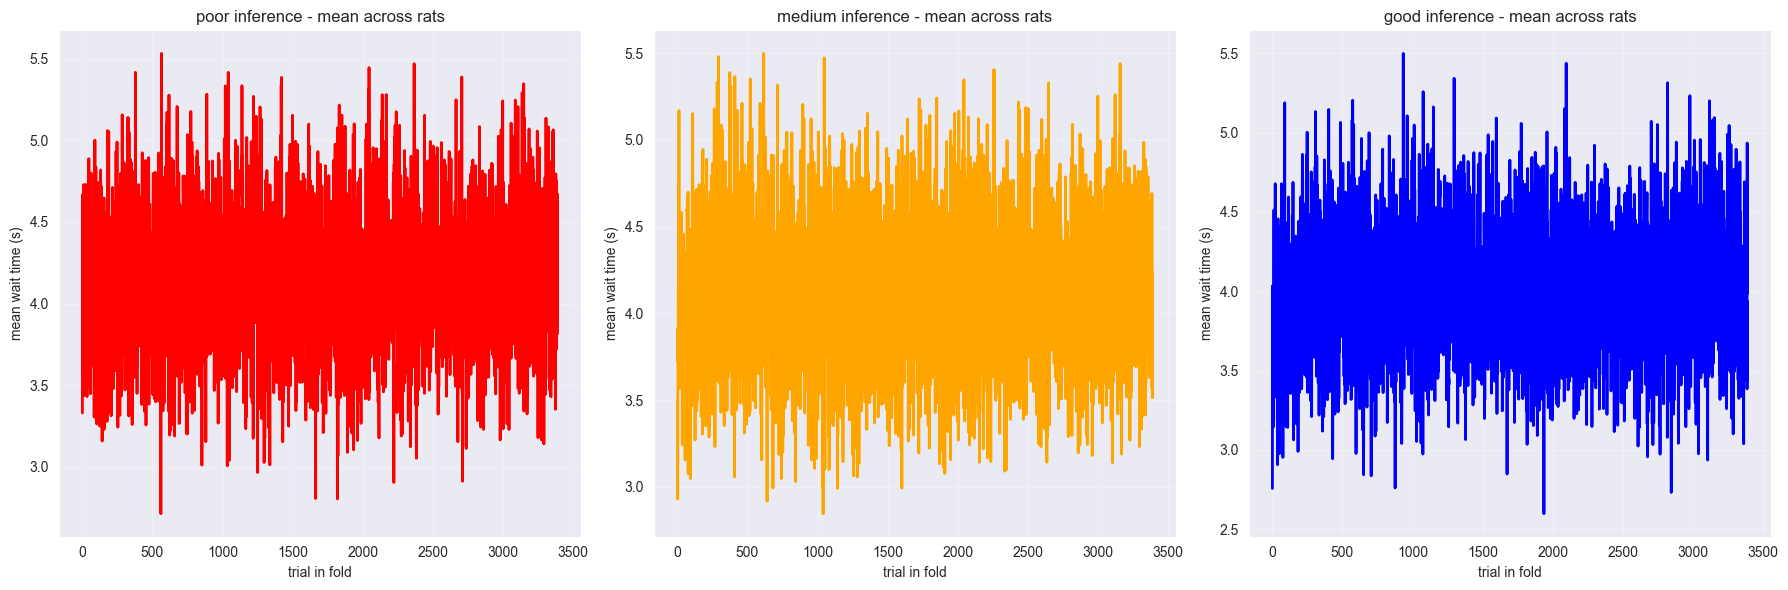

In [56]:
# plot 2: mean across rats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, inf_type in enumerate(inference_types):
    ax = axes[i]
    
    # collect all curves for this inference type
    curves_matrix = []
    for rat, curve in all_rat_curves[inf_type].items():
        trimmed_curve = curve.iloc[:min_length]
        curves_matrix.append(trimmed_curve.values)
    
    curves_matrix = np.array(curves_matrix)
    
    # calculate mean across rats
    mean_curve = np.mean(curves_matrix, axis=0)
    trial_indices = np.arange(min_length)
    
    # plot mean
    ax.plot(trial_indices, mean_curve, color=colors[inf_type], linewidth=2)
    
    ax.set_title(f'{inf_type} inference - mean across rats')
    ax.set_xlabel('trial in fold')
    ax.set_ylabel('mean wait time (s)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

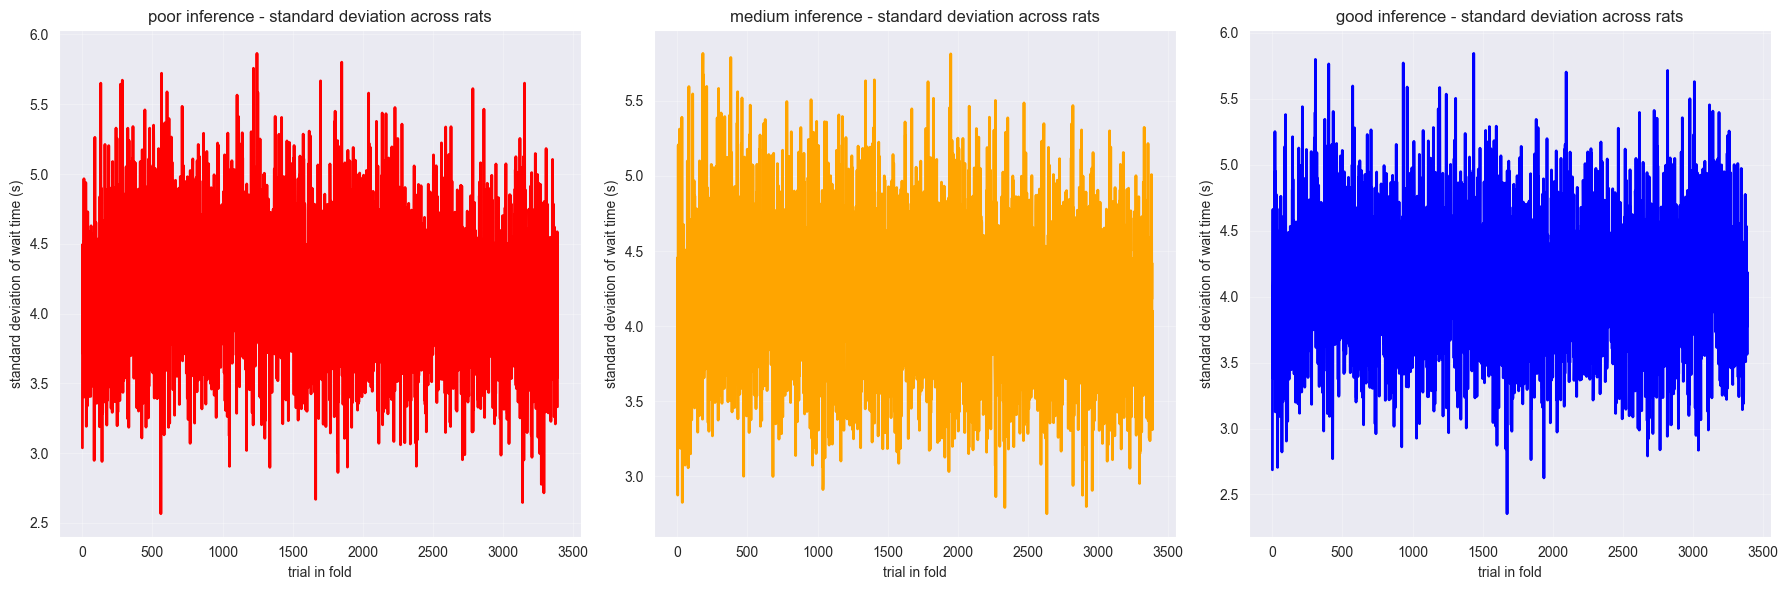

In [57]:
# plot 3: standard deviation across rats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, inf_type in enumerate(inference_types):
    ax = axes[i]
    
    # collect all curves for this inference type
    curves_matrix = []
    for rat, curve in all_rat_curves[inf_type].items():
        trimmed_curve = curve.iloc[:min_length]
        curves_matrix.append(trimmed_curve.values)
    
    curves_matrix = np.array(curves_matrix)
    
    # calculate standard deviation across rats
    std_curve = np.std(curves_matrix, axis=0)
    trial_indices = np.arange(min_length)
    
    # plot standard deviation
    ax.plot(trial_indices, std_curve, color=colors[inf_type], linewidth=2)
    
    ax.set_title(f'{inf_type} inference - standard deviation across rats')
    ax.set_xlabel('trial in fold')
    ax.set_ylabel('standard deviation of wait time (s)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

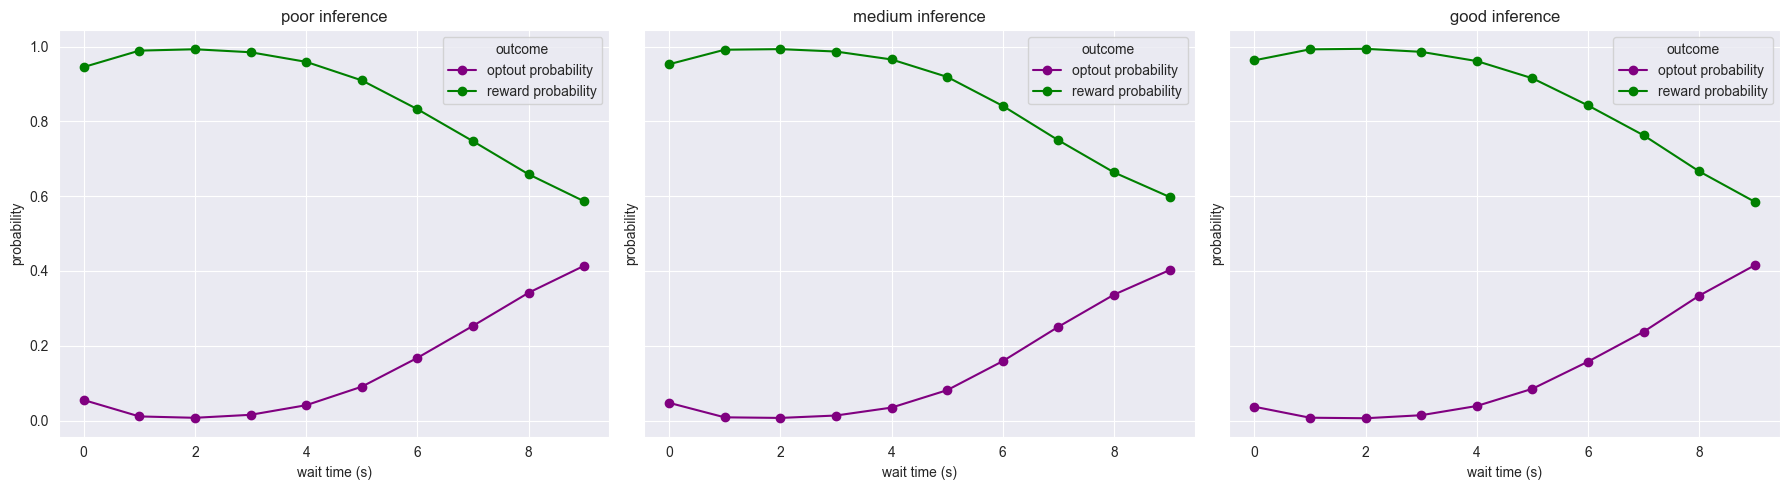

In [58]:
# optout probability analysis by inference type
bins = np.arange(0, 10.5, 1)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, inf_type in zip(axes, inference_types):
    sub = train_merged.query("inference_type == @inf_type")
    opt, rew = get_optout_probability(sub, wait_time_bins=bins, ax=ax)
    ax.set_title(f"{inf_type} inference")
    ax.set_xlabel("wait time (s)")
    ax.set_ylabel("probability")
    ax.lines[0].set_label("optout probability")
    ax.lines[1].set_label("reward probability")
    ax.legend(title="outcome")
plt.tight_layout()
plt.show()

In [70]:
# create block transition variables for transition dynamics analysis
train_merged = train_merged.sort_values(['rat', 'Fold', 'trial_in_fold'])

# block mapping - 1=Mixed, 2=High, 3=Low
train_merged['block_type'] = train_merged['block'].map({1: 'Mixed', 2: 'High', 3: 'Low'})
train_merged['prev_block_type'] = train_merged.groupby(['rat', 'Fold'])['block_type'].shift(1)

# create block transition type (only for actual transitions where both blocks are known)
train_merged['prev_block'] = train_merged.groupby(['rat', 'Fold'])['block'].shift(1)
train_merged['block_transition'] = (train_merged['prev_block'] != train_merged['block']) & pd.notna(train_merged['prev_block'])

# create transition type labels only for valid transitions with valid block types
def create_transition_label(row):
    if row['block_transition'] and pd.notna(row['prev_block_type']) and pd.notna(row['block_type']):
        return f"{row['prev_block_type']}→{row['block_type']}"
    else:
        return None

train_merged['transition_type'] = train_merged.apply(create_transition_label, axis=1)

# define valid transitions
valid_transitions = ['Mixed→High', 'High→Mixed', 'Mixed→Low', 'Low→Mixed']

# filter for only valid transition trials
transition_trials = train_merged[
    (train_merged['block_transition'] == True) &
    (pd.notna(train_merged['transition_type'])) &
    (train_merged['transition_type'].isin(valid_transitions))
].copy()

print("Block transition summary:")
print(transition_trials['transition_type'].value_counts())
print(f"\nTotal transition trials: {len(transition_trials)}")

Block transition summary:
transition_type
Mixed→Low     129241
Low→Mixed     128655
Mixed→High    128081
High→Mixed    127915
Name: count, dtype: int64

Total transition trials: 513892


In [80]:
# analyze block transition dynamics by inference type
def analyze_block_transitions(df, inference_type):
    """
    analyze block transition dynamics for a given inference type
    """
    subset = df[df['inference_type'] == inference_type].copy()
    
    # get transition trials only
    trans_trials = subset[subset['block_transition'] == True].copy()
    
    if len(trans_trials) == 0:
        return {}
    
    transition_data = {}
    
    # analyze each transition type
    for trans_type in trans_trials['transition_type'].dropna().unique():
        trans_subset = trans_trials[trans_trials['transition_type'] == trans_type]
        
        if len(trans_subset) > 10:
            # calculate mean wait time by trial position
            trans_curve = trans_subset.groupby('trial_in_fold')['wait_time'].mean()
            transition_data[trans_type] = trans_curve
    
    return transition_data

# analyze transitions for all inference types
transition_results = {}
for inf_type in inference_types:
    transition_results[inf_type] = analyze_block_transitions(transition_trials, inf_type)

# print results
for inf_type in inference_types:
    print(f"{inf_type} inference transitions found: {list(transition_results[inf_type].keys())}")

poor inference transitions found: ['Mixed→Low', 'Low→Mixed', 'Mixed→High', 'High→Mixed']
medium inference transitions found: ['Mixed→Low', 'Low→Mixed', 'Mixed→High', 'High→Mixed']
good inference transitions found: ['Mixed→High', 'High→Mixed', 'Mixed→Low', 'Low→Mixed']


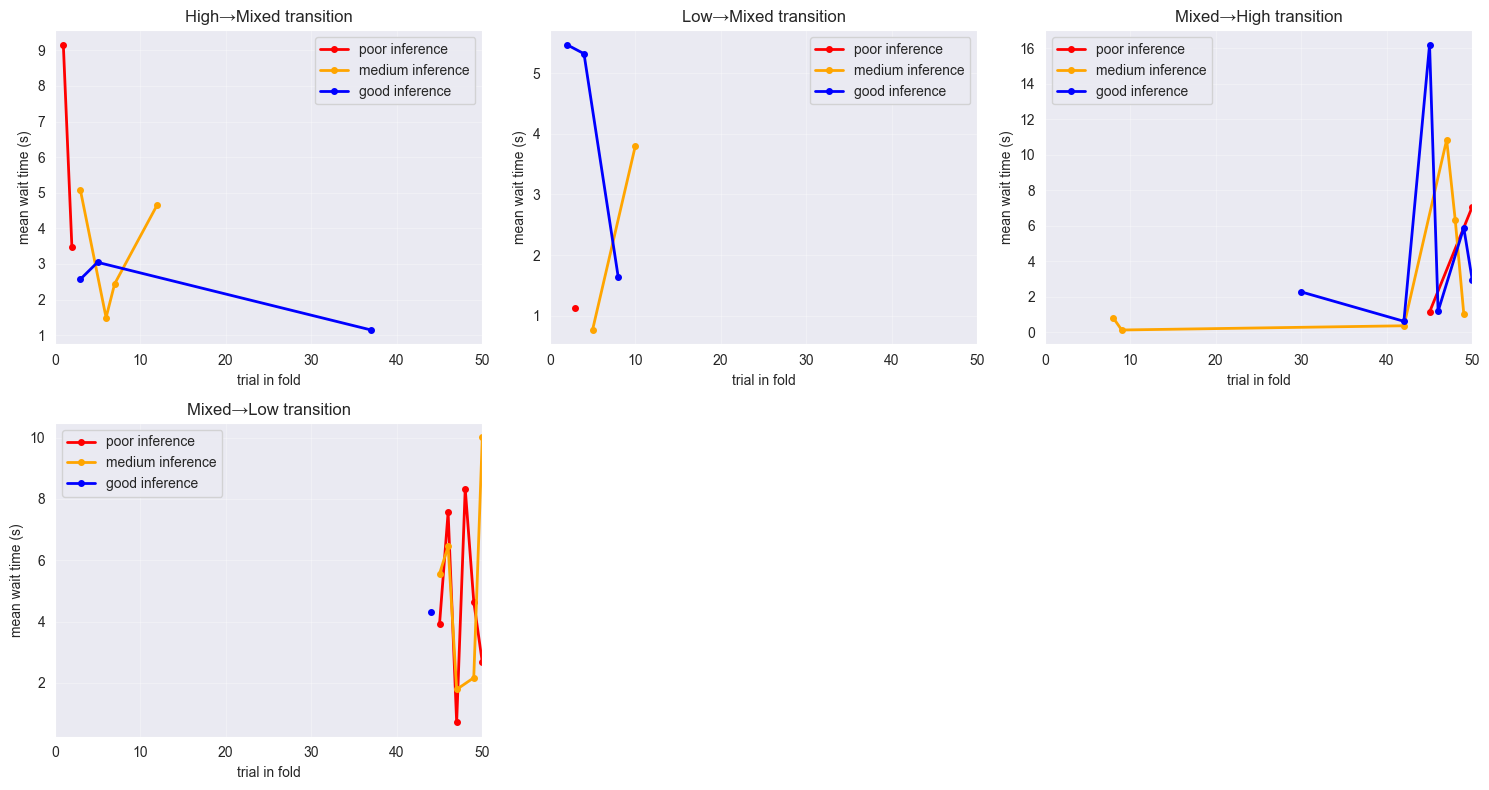

In [81]:
# plot block transition dynamics
def plot_block_transition_dynamics(transition_results, max_trials=50):
    """
    plot how block transitions affect wait times across inference types
    """
    # get all unique transition types across all inference types
    all_transitions = set()
    for inf_type in inference_types:
        all_transitions.update(transition_results[inf_type].keys())
    
    all_transitions = sorted(list(all_transitions))
    
    if not all_transitions:
        print("no transitions found")
        return
    
    # create subplots
    n_transitions = len(all_transitions)
    n_cols = min(3, n_transitions)
    n_rows = (n_transitions + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, trans_type in enumerate(all_transitions):
        ax = axes[i] if n_transitions > 1 else axes
        
        # plot each inference type
        for inf_type in inference_types:
            if trans_type in transition_results[inf_type]:
                data = transition_results[inf_type][trans_type]
                # filter to only show first max_trials
                data_filtered = data[data.index <= max_trials]
                
                if len(data_filtered) > 0:
                    ax.plot(data_filtered.index, data_filtered.values,
                           label=f'{inf_type} inference', 
                           color=colors[inf_type], 
                           linewidth=2, marker='o', markersize=4)
        
        ax.set_title(f'{trans_type} transition')
        ax.set_xlabel('trial in fold')
        ax.set_ylabel('mean wait time (s)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, max_trials)  # force x-axis limit
    
    # hide empty subplots
    for i in range(n_transitions, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# plot the transition dynamics - showing only first 50 trials
plot_block_transition_dynamics(transition_results, max_trials=50)

In [82]:
# summary statistics for block transitions
print("\nBlock transition statistics by inference type:")
for inf_type in inference_types:
    subset = transition_trials[transition_trials['inference_type'] == inf_type]
    
    print(f"\n{inf_type.capitalize()} inference:")
    print(f"  Total transition trials: {len(subset)}")
    print(f"  Mean wait time on transitions: {subset['wait_time'].mean():.2f}s")
    print(f"  Transition type breakdown:")
    
    for trans_type in subset['transition_type'].dropna().unique():
        trans_subset = subset[subset['transition_type'] == trans_type]
        print(f"    {trans_type}: {len(trans_subset)} trials, mean wait: {trans_subset['wait_time'].mean():.2f}s")


Block transition statistics by inference type:

Poor inference:
  Total transition trials: 166651
  Mean wait time on transitions: 4.02s
  Transition type breakdown:
    Mixed→Low: 41778 trials, mean wait: 3.91s
    Low→Mixed: 41596 trials, mean wait: 4.02s
    Mixed→High: 41674 trials, mean wait: 4.21s
    High→Mixed: 41603 trials, mean wait: 3.96s

Medium inference:
  Total transition trials: 150002
  Mean wait time on transitions: 4.02s
  Transition type breakdown:
    Mixed→Low: 38084 trials, mean wait: 3.79s
    Low→Mixed: 37819 trials, mean wait: 4.09s
    Mixed→High: 37063 trials, mean wait: 4.29s
    High→Mixed: 37036 trials, mean wait: 3.93s

Good inference:
  Total transition trials: 197239
  Mean wait time on transitions: 3.92s
  Transition type breakdown:
    Mixed→High: 49344 trials, mean wait: 4.12s
    High→Mixed: 49276 trials, mean wait: 3.81s
    Mixed→Low: 49379 trials, mean wait: 3.72s
    Low→Mixed: 49240 trials, mean wait: 4.03s


In [83]:
# basic wait time statistics for each inference type
print("\nWait time statistics by inference type:")
for inf_type in inference_types:
    subset_wait = train_merged[train_merged['inference_type'] == inf_type]['wait_time']
    valid_values = subset_wait[~np.isnan(subset_wait)]
    
    mean_wait = np.mean(valid_values)
    std_wait = np.std(valid_values)
    num_values = len(valid_values)
    
    print(f"\n{inf_type.capitalize()} inference:")
    print(f"  Mean wait time: {mean_wait:.2f}s")
    print(f"  Std dev: {std_wait:.2f}s")
    print(f"  Number of trials: {num_values}")

# apply optout summary stats function by inference type
def get_optout_summary_stats_by_inference(merged_df, inference_type, wait_time_bins=np.arange(0, 10.5, 1)):
    """
    modified version of function to work with merged dataframe and inference type
    """
    beh_df = merged_df[merged_df['inference_type'] == inference_type].copy()
    
    # calculate catch probability
    prob_catch = beh_df['catch'].mean()
    
    # bin opt-out probabilities
    optout_prob = np.zeros(len(wait_time_bins) - 1)
    for i in range(len(wait_time_bins) - 1):
        trials = beh_df[(beh_df['wait_time'] >= wait_time_bins[i]) &
                        (beh_df['wait_time'] < wait_time_bins[i + 1]) &
                        (beh_df['vios'] == 0) &
                        (beh_df['catch'] == 0)]
        optout_prob[i] = trials['optout'].mean() if len(trials) > 10 else np.nan
    
    # threshold-time: first rise above 5% of max
    try:
        optout_max = np.nanmax(optout_prob)
        threshold_cutoff = 0.05 * optout_max
        above_cutoff = np.where(optout_prob > threshold_cutoff)[0]
        
        if len(above_cutoff) > 0:
            threshold_idx = above_cutoff[0]
            threshold_time = wait_time_bins[threshold_idx]
        else:
            threshold_time = np.nan
    except Exception:
        threshold_time = np.nan
    
    # estimate slope after that time (linear regression on post-threshold)
    x = wait_time_bins[:-1]
    y = optout_prob
    valid_idx = (x > threshold_time) & ~np.isnan(y)
    
    if np.sum(valid_idx) >= 2:
        slope, _, _, _, _ = linregress(x[valid_idx], y[valid_idx])
    else:
        slope = np.nan
    
    return {
        'prob_catch': prob_catch,
        'threshold_time': threshold_time,
        'post_threshold_slope': slope,
        'inference_type': inference_type
    }

# get summary stats for all inference types
print("\nOptout summary statistics:")
inference_summary = []
for inf_type in inference_types:
    stats = get_optout_summary_stats_by_inference(train_merged, inf_type)
    inference_summary.append(stats)
    
    print(f"\n{inf_type.capitalize()} inference:")
    print(f"  Prob catch: {stats['prob_catch']:.3f}")
    print(f"  Threshold time: {stats['threshold_time']:.3f}")
    print(f"  Post-threshold slope: {stats['post_threshold_slope']:.3f}")


Wait time statistics by inference type:

Poor inference:
  Mean wait time: 4.06s
  Std dev: 4.50s
  Number of trials: 6568252

Medium inference:
  Mean wait time: 4.04s
  Std dev: 4.54s
  Number of trials: 5899240

Good inference:
  Mean wait time: 3.94s
  Std dev: 4.40s
  Number of trials: 7777956

Optout summary statistics:

Poor inference:
  Prob catch: 0.184
  Threshold time: 0.000
  Post-threshold slope: 0.054

Medium inference:
  Prob catch: 0.177
  Threshold time: 0.000
  Post-threshold slope: 0.053

Good inference:
  Prob catch: 0.168
  Threshold time: 0.000
  Post-threshold slope: 0.053


In [84]:
# summary of results
print("\nKey findings:")
for inf_type in inference_types:
    data = train_merged[train_merged['inference_type'] == inf_type]
    rat_count = len(lam[lam['inference_type'] == inf_type])
    
    print(f"\n{inf_type.capitalize()} inference:")
    print(f"  Number of rats: {rat_count}")
    print(f"  Mean wait time: {data['wait_time'].mean():.2f}s")
    print(f"  Optout rate: {data['optout'].mean():.3f}")
    print(f"  Lambda range: {lam[lam['inference_type'] == inf_type]['lambda_median'].min():.3f} - {lam[lam['inference_type'] == inf_type]['lambda_median'].max():.3f}")


Key findings:

Poor inference:
  Number of rats: 103
  Mean wait time: 4.06s
  Optout rate: 0.228
  Lambda range: 0.000 - 0.376

Medium inference:
  Number of rats: 104
  Mean wait time: 4.04s
  Optout rate: 0.218
  Lambda range: 0.391 - 0.803

Good inference:
  Number of rats: 103
  Mean wait time: 3.94s
  Optout rate: 0.206
  Lambda range: 0.807 - 0.996
